In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
torch.set_default_dtype(torch.float64)

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.sampling import draw_sobol_samples

## Multi-objective (two functions)

Two functions are created by using 2 GPs to fit a sine and a cosine function separately (with noise). We use the obtained GP posterior means as our objective functions.

In [2]:
bounds = torch.tensor([[-3.], [3.]])

In [3]:
def sin(x, noise=True):
    if noise:
        return torch.sin(x*2*torch.pi) + torch.rand(x.shape)
    else:
        return torch.sin(x*2*torch.pi)

def cos(x, noise=True):
    if noise:
        return torch.cos(x*2*torch.pi) + torch.rand(x.shape)
    else:
        return torch.cos(x*2*torch.pi)

### Create objective functions via GPs

In [4]:
x1_observed = np.random.uniform(*bounds, 20).reshape(-1, 1)
x1_observed = torch.tensor(x1_observed)
y1_observed = sin(x1_observed)

x2_observed = np.random.uniform(*bounds, 20).reshape(-1, 1)
x2_observed = torch.tensor(x2_observed)
y2_observed = cos(x2_observed)

x_dense = np.linspace(*bounds, 1000).reshape(-1, 1)
x_dense = torch.tensor(x_dense)

In [5]:
gp1 = SingleTaskGP(x1_observed, y1_observed)
mll1 = ExactMarginalLogLikelihood(gp1.likelihood, gp1)
fit_gpytorch_mll(mll1)
with torch.no_grad():
    gp1_posterior = gp1.posterior(x_dense)

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5804]), std = tensor([0.7943])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [6]:
gp2 = SingleTaskGP(x2_observed, y2_observed)
mll2 = ExactMarginalLogLikelihood(gp2.likelihood, gp2)
fit_gpytorch_mll(mll2)
with torch.no_grad():
    gp2_posterior = gp2.posterior(x_dense)

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7034]), std = tensor([0.6413])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


### Find non-dominated points (pareto front)

In [7]:
y_dense= torch.stack([gp1_posterior.mean, gp2_posterior.mean]).T
pareto = is_non_dominated(y_dense)

y1_pareto = []
y2_pareto = []
for n, p in enumerate(pareto[0]):
    y1_pareto.append(gp1_posterior.mean.numpy()[n].item() if p else np.nan)
    y2_pareto.append(gp2_posterior.mean.numpy()[n].item() if p else np.nan)

/tmp/ipykernel_234033/1904577359.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449039270/work/aten/src/ATen/native/TensorShape.cpp:3614.)
  y_dense= torch.stack([gp1_posterior.mean, gp2_posterior.mean]).T


### Visualize pareto front

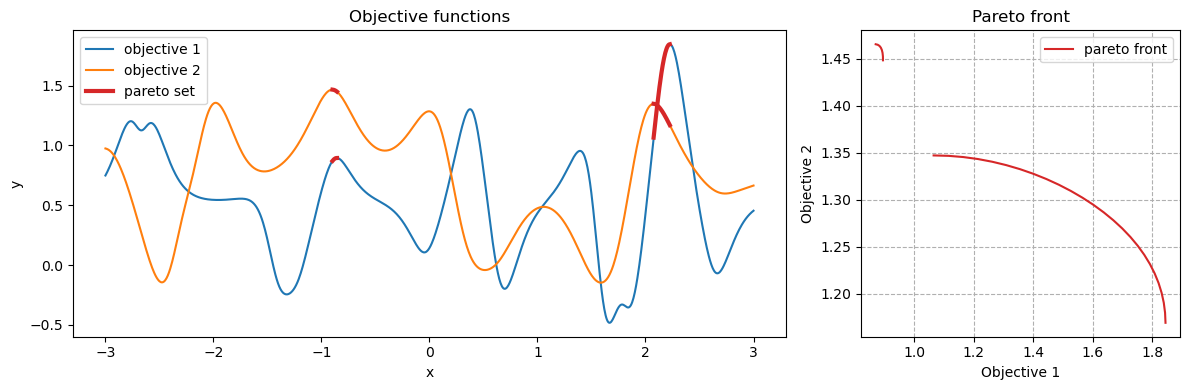

In [8]:
plt.figure(figsize=(12, 4))
ax_func = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax_func.plot(x_dense, gp1_posterior.mean, label="objective 1")
ax_func.plot(x_dense, gp2_posterior.mean, label="objective 2")
ax_func.plot(x_dense, y1_pareto, color='tab:red', linewidth=3, label="pareto set")
ax_func.plot(x_dense, y2_pareto, color='tab:red', linewidth=3)
ax_func.set_xlabel("x")
ax_func.set_ylabel("y")
ax_func.set_title("Objective functions")
ax_func.legend()

ax_pareto = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax_pareto.plot(y1_pareto, y2_pareto, label='pareto front', color='tab:red')
ax_pareto.grid(linestyle='--')
ax_pareto.set_xlabel("Objective 1")
ax_pareto.set_ylabel("Objective 2")
ax_pareto.set_title("Pareto front")
ax_pareto.legend()

plt.tight_layout()

## Multiobjective BO via expected hypervolume improvement (EHVI)

In [9]:
num_init = 2
x_observed = draw_sobol_samples(bounds=bounds, n=num_init, q=1).squeeze(1)

with torch.no_grad():
    y1 = gp1.posterior(x_observed).mean.squeeze()
    y2 = gp2.posterior(x_observed).mean.squeeze()

y_observed = torch.stack([y1, y2]).T

### Initial observations

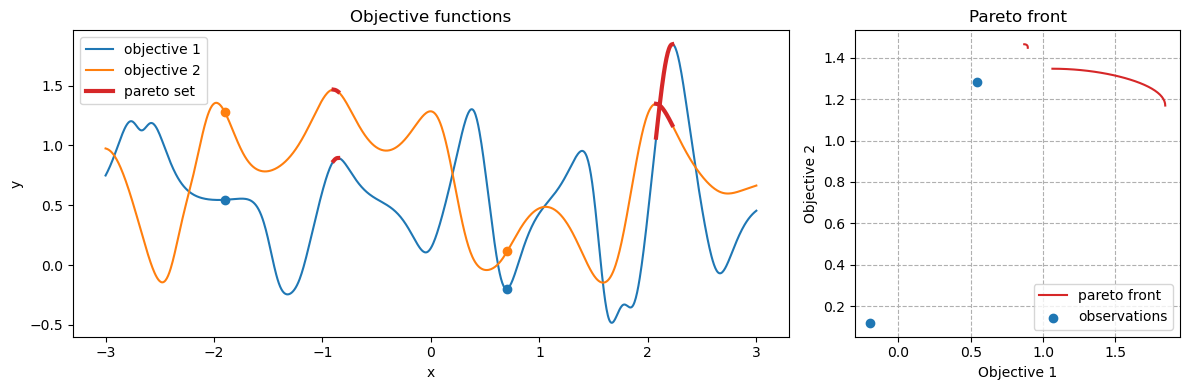

In [10]:
plt.figure(figsize=(12, 4))
ax_func = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax_func.plot(x_dense, gp1_posterior.mean, label="objective 1")
ax_func.plot(x_dense, gp2_posterior.mean, label="objective 2")
ax_func.plot(x_dense, y1_pareto, color='tab:red', linewidth=3, label="pareto set")
ax_func.plot(x_dense, y2_pareto, color='tab:red', linewidth=3)
ax_func.scatter(x_observed, y1, color="tab:blue")
ax_func.scatter(x_observed, y2, color="tab:orange")
ax_func.set_xlabel("x")
ax_func.set_ylabel("y")
ax_func.set_title("Objective functions")
ax_func.legend()

ax_pareto = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax_pareto.plot(y1_pareto, y2_pareto, label='pareto front', color='tab:red')
ax_pareto.scatter(*y_observed.T, label="observations")
ax_pareto.grid(linestyle='--')
ax_pareto.set_xlabel("Objective 1")
ax_pareto.set_ylabel("Objective 2")
ax_pareto.set_title("Pareto front")
ax_pareto.legend()

plt.tight_layout()

In [11]:
def initialize_model(x_observed, y_observed):
    models = []
    
    for i in range(y_observed.shape[-1]):
        models.append(
            SingleTaskGP(x_observed, y_observed[:, i][..., None])
        )

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [12]:
def optimize_qnehvi(model, x_observed):
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=[-6., -6.],
        X_baseline=x_observed,
        prune_baseline=True,
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=3,
        raw_samples=4,
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True
    )
    with torch.no_grad():
        y1 = gp1.posterior(candidates).mean.squeeze()
        y2 = gp2.posterior(candidates).mean.squeeze()

    new_obj = torch.stack([y1, y2]).T
    return candidates, new_obj

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

def plot_mobo_obs(x_observed, y_observed, num_init, num_iterations):
    fig = plt.figure(figsize=(12, 4))

    num_batch = len(x_observed) / 1
    batch_num = np.repeat(np.arange(num_batch), 1)

    ax_func = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax_func.plot(x_dense, gp1_posterior.mean, label="objective 1")
    ax_func.plot(x_dense, gp2_posterior.mean, label="objective 2")
    ax_func.plot(x_dense, y1_pareto, color='tab:red', linewidth=3, label="pareto set")
    ax_func.plot(x_dense, y2_pareto, color='tab:red', linewidth=3)
    ax_func.scatter(x_observed, y_observed[:, 0].reshape(x_observed.shape), s=10,c=batch_num)
    ax_func.scatter(x_observed, y_observed[:, 1].reshape(x_observed.shape), s=10,c=batch_num)
    ax_func.set_xlabel("x")
    ax_func.set_ylabel("y")
    ax_func.set_title("Objective functions")
    ax_func.legend()

    ax_pareto = plt.subplot2grid((1, 3), (0, 2), colspan=1)
    ax_pareto.plot(y1_pareto, y2_pareto, label='pareto front', color='tab:red')
    ax_pareto.scatter(*y_observed.T, label="observations", s=10, c=batch_num)
    
    pareto = is_non_dominated(y_observed)
    sort_idx = np.argsort(y_observed[pareto][:, 0])
    ax_pareto.plot(*y_observed[pareto][sort_idx].T, label='approximated pareto front', color='tab:pink')
    
    ax_pareto.grid(linestyle='--')
    ax_pareto.set_xlabel("Objective 1")
    ax_pareto.set_ylabel("Objective 2")
    ax_pareto.set_title("Pareto front")
    ax_pareto.legend()
    
    norm = plt.Normalize(0, num_iterations + num_init)
    sm =  ScalarMappable(norm=norm, cmap=cm)
    divider = make_axes_locatable(ax_pareto)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.set_title("Iteration")

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_234033/1327709866.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


In [14]:
ref_point = torch.tensor([-6., -6.])
hvs_qnehvi = []

mll_qnehvi, model_qnehvi = initialize_model(x_observed, y_observed)
bd = DominatedPartitioning(ref_point=ref_point, Y=y_observed)
volume = bd.compute_hypervolume().item()
hvs_qnehvi.append(volume)

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1748]), std = tensor([0.5240])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7005]), std = tensor([0.8224])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


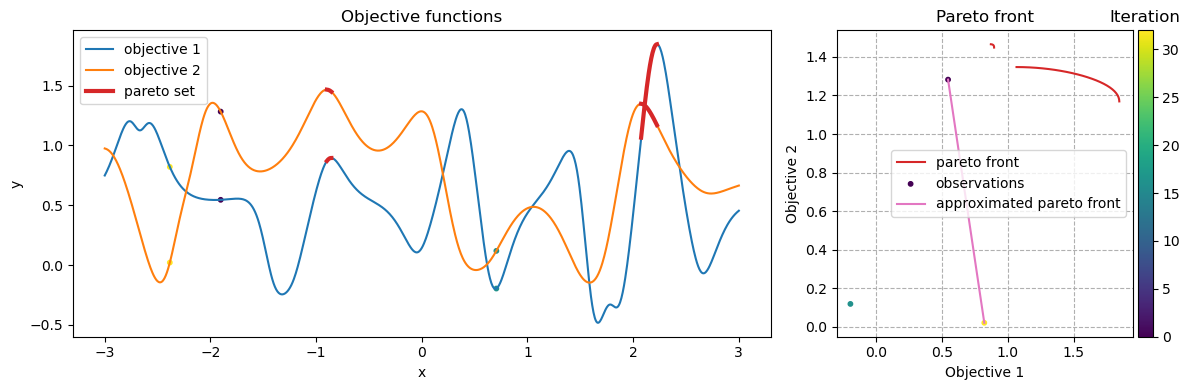

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3900]), std = tensor([0.5255])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4741]), std = tensor([0.7015])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is

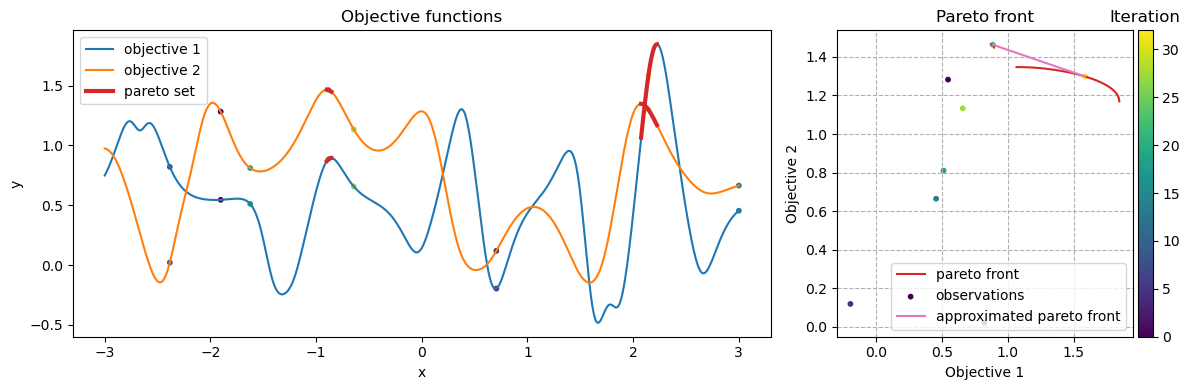

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6578]), std = tensor([0.4991])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8489]), std = tensor([0.5478])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is

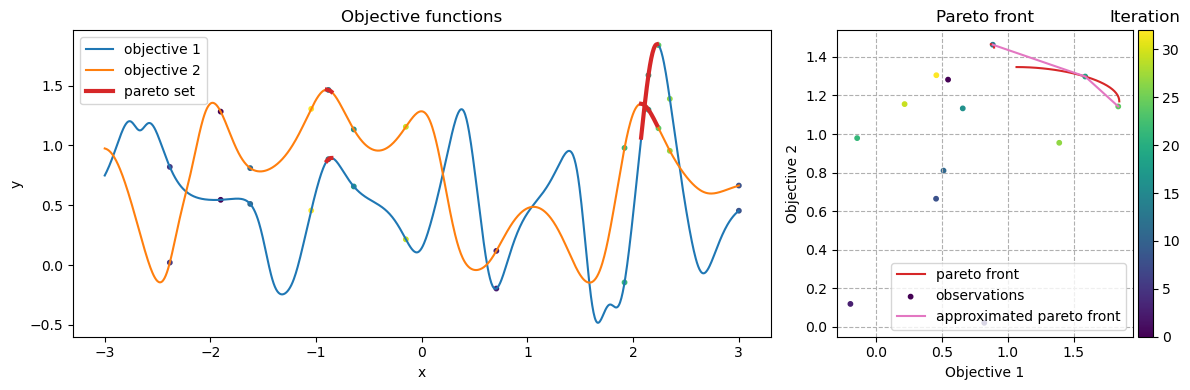

/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.6935]), std = tensor([0.6145])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9483]), std = tensor([0.4462])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is

In [15]:
num_iterations = 30
for iterations in range(num_iterations):
    fit_gpytorch_mll(mll_qnehvi)
    new_x_qnehvi, new_obj_qnehvi = optimize_qnehvi(model_qnehvi, x_observed)
    x_observed = torch.cat([x_observed, new_x_qnehvi])
    y_observed = torch.cat([y_observed, new_obj_qnehvi[None, ...]])

    bd = DominatedPartitioning(ref_point=ref_point, Y=-y_observed)
    volume = bd.compute_hypervolume().item()
    hvs_qnehvi.append(volume)

    if iterations % 5 == 0:
        plot_mobo_obs(x_observed, y_observed, num_init, num_iterations)
    mll_qnehvi, model_qnehvi = initialize_model(x_observed, y_observed)